In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input, LSTM , add
from tensorflow.keras.utils import plot_model


In [3]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [4]:
# Load ResNet152 without the top fully connected layers and apply global average pooling
model = ResNet152(include_top=False, weights='imagenet', pooling='avg')

# Freeze the ResNet layers
model.trainable = False
# Summarize the model
model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet152"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [5]:
features_dir ='/kaggle/input/features'

In [6]:
# load features from pickle
with open(os.path.join(features_dir, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['103106960_e8a41d64f8']

['A boy with a stick kneeling in front of a goalie net',
 'A child in a red jacket playing street hockey guarding a goal .',
 'A young kid playing the goalie in a hockey rink .',
 'A young male kneeling in front of a hockey goal with a hockey stick in his right hand .',
 '"Hockey goalie boy in red jacket crouches by goal   with stick ."']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['103106960_e8a41d64f8']

['startseq boy with stick kneeling in front of goalie net endseq',
 'startseq child in red jacket playing street hockey guarding goal endseq',
 'startseq young kid playing the goalie in hockey rink endseq',
 'startseq young male kneeling in front of hockey goal with hockey stick in his right hand endseq',
 'startseq "hockey goalie boy in red jacket crouches by goal with stick ." endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

max_length = 35
vocab_size = 8485

# Define model architecture
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_bias=False, recurrent_activation='sigmoid')(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Print model summary to ensure proper setup
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 35)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 2048)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,172,160 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    524,288 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  2,180,645 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,467,429 (20.86 MB)

 Trainable params: 5,467,429 (20.86 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses TensorFlow warnings, errors are still shown


In [25]:
# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  1/227 ━━━━━━━━━━━━━━━━━━━━ 29:50 8s/step - loss: 9.0767

I0000 00:00:1724151945.034453     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724151945.063687     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151945.086443     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151945.118852     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/227 ━━━━━━━━━━━━━━━━━━━━ 17:58 5s/step - loss: 8.9960

W0000 00:00:1724151949.859438     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151949.881004     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151949.910501     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/227 ━━━━━━━━━━━━━━━━━━━━ 18:05 5s/step - loss: 8.8913

W0000 00:00:1724151954.757845     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151954.779095     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151954.807707     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/227 ━━━━━━━━━━━━━━━━━━━━ 17:57 5s/step - loss: 8.7507

W0000 00:00:1724151959.559579     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151959.581365     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151959.610731     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  6/227 ━━━━━━━━━━━━━━━━━━━━ 14:22 4s/step - loss: 8.4519

W0000 00:00:1724151964.484259     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151964.506019     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151964.535637     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/227 ━━━━━━━━━━━━━━━━━━━━ 15:03 4s/step - loss: 8.3189

W0000 00:00:1724151969.698555     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151969.720717     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151969.750753     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/227 ━━━━━━━━━━━━━━━━━━━━ 15:21 4s/step - loss: 8.2033

W0000 00:00:1724151974.520486     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151974.542181     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151974.571742     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/227 ━━━━━━━━━━━━━━━━━━━━ 15:35 4s/step - loss: 8.1027

W0000 00:00:1724151979.407395     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151979.429204     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151979.459087     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/227 ━━━━━━━━━━━━━━━━━━━━ 15:48 4s/step - loss: 8.0137

W0000 00:00:1724151984.409549     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151984.432095     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151984.462237     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/227 ━━━━━━━━━━━━━━━━━━━━ 15:56 4s/step - loss: 7.9317

W0000 00:00:1724151989.346225     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151989.367775     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151989.397019     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/227 ━━━━━━━━━━━━━━━━━━━━ 16:04 4s/step - loss: 7.8565

W0000 00:00:1724151994.382558     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151994.405396     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151994.437387     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 13/227 ━━━━━━━━━━━━━━━━━━━━ 16:09 5s/step - loss: 7.7881

W0000 00:00:1724151999.429998     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151999.452113     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724151999.481908     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/227 ━━━━━━━━━━━━━━━━━━━━ 16:14 5s/step - loss: 7.7259

W0000 00:00:1724152004.549834     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152004.571852     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152004.601345     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/227 ━━━━━━━━━━━━━━━━━━━━ 16:15 5s/step - loss: 7.6690

W0000 00:00:1724152009.490259     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152009.511509     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152009.540148     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/227 ━━━━━━━━━━━━━━━━━━━━ 16:19 5s/step - loss: 7.6171

W0000 00:00:1724152014.696152     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152014.717704     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152014.747013     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/227 ━━━━━━━━━━━━━━━━━━━━ 16:22 5s/step - loss: 7.5692

W0000 00:00:1724152019.934580     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152019.955891     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152019.985074     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/227 ━━━━━━━━━━━━━━━━━━━━ 16:23 5s/step - loss: 7.5239

W0000 00:00:1724152025.097983     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152025.119325     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152025.148666     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/227 ━━━━━━━━━━━━━━━━━━━━ 16:23 5s/step - loss: 7.4815

W0000 00:00:1724152030.218184     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152030.240137     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152030.269609     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/227 ━━━━━━━━━━━━━━━━━━━━ 16:21 5s/step - loss: 7.4422

W0000 00:00:1724152035.192442     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152035.213527     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152035.242519     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/227 ━━━━━━━━━━━━━━━━━━━━ 16:20 5s/step - loss: 7.4050

W0000 00:00:1724152040.285575     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152040.307187     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152040.336350     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/227 ━━━━━━━━━━━━━━━━━━━━ 16:20 5s/step - loss: 7.3695

W0000 00:00:1724152045.454711     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152045.477316     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152045.507548     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 23/227 ━━━━━━━━━━━━━━━━━━━━ 16:17 5s/step - loss: 7.3358

W0000 00:00:1724152050.501510     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152050.523510     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152050.553396     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/227 ━━━━━━━━━━━━━━━━━━━━ 16:15 5s/step - loss: 7.3039

W0000 00:00:1724152055.570596     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152055.592935     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152055.622792     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 25/227 ━━━━━━━━━━━━━━━━━━━━ 16:12 5s/step - loss: 7.2734

W0000 00:00:1724152060.629046     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152060.650357     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152060.679459     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/227 ━━━━━━━━━━━━━━━━━━━━ 16:10 5s/step - loss: 7.2446

W0000 00:00:1724152065.792012     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152065.813382     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152065.842683     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/227 ━━━━━━━━━━━━━━━━━━━━ 16:08 5s/step - loss: 7.2174

W0000 00:00:1724152070.972854     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152070.994913     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152071.024585     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 29/227 ━━━━━━━━━━━━━━━━━━━━ 15:28 5s/step - loss: 7.1665

W0000 00:00:1724152076.283055     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152076.304558     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152076.333805     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/227 ━━━━━━━━━━━━━━━━━━━━ 14:52 5s/step - loss: 7.1199

W0000 00:00:1724152081.727149     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152081.749113     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152081.778766     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 32/227 ━━━━━━━━━━━━━━━━━━━━ 14:53 5s/step - loss: 7.0978

W0000 00:00:1724152087.099337     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152087.120687     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152087.150045     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 34/227 ━━━━━━━━━━━━━━━━━━━━ 14:22 4s/step - loss: 7.0561

W0000 00:00:1724152092.449469     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152092.472266     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152092.503082     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/227 ━━━━━━━━━━━━━━━━━━━━ 14:23 4s/step - loss: 7.0362

W0000 00:00:1724152097.894938     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152097.917142     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152097.946706     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/227 ━━━━━━━━━━━━━━━━━━━━ 14:22 5s/step - loss: 7.0169

W0000 00:00:1724152103.113047     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152103.135395     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152103.164839     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/227 ━━━━━━━━━━━━━━━━━━━━ 14:21 5s/step - loss: 6.9983

W0000 00:00:1724152108.305969     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152108.327184     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152108.357171     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/227 ━━━━━━━━━━━━━━━━━━━━ 14:21 5s/step - loss: 6.9803

W0000 00:00:1724152113.672210     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152113.693930     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152113.723329     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/227 ━━━━━━━━━━━━━━━━━━━━ 14:20 5s/step - loss: 6.9628

W0000 00:00:1724152119.071421     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152119.093074     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152119.122359     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/227 ━━━━━━━━━━━━━━━━━━━━ 14:20 5s/step - loss: 6.9458

W0000 00:00:1724152124.427256     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152124.449260     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152124.478743     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/227 ━━━━━━━━━━━━━━━━━━━━ 14:18 5s/step - loss: 6.9293

W0000 00:00:1724152129.718027     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152129.740130     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152129.770026     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/227 ━━━━━━━━━━━━━━━━━━━━ 14:17 5s/step - loss: 6.9133

W0000 00:00:1724152134.997766     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152135.019452     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152135.048635     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 44/227 ━━━━━━━━━━━━━━━━━━━━ 13:50 5s/step - loss: 6.8825

W0000 00:00:1724152140.136484     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152140.159134     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152140.190302     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/227 ━━━━━━━━━━━━━━━━━━━━ 13:49 5s/step - loss: 6.8676

W0000 00:00:1724152145.493723     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152145.514883     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152145.543776     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/227 ━━━━━━━━━━━━━━━━━━━━ 13:46 5s/step - loss: 6.8530

W0000 00:00:1724152150.517672     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152150.538572     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152150.566925     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/227 ━━━━━━━━━━━━━━━━━━━━ 13:44 5s/step - loss: 6.8386

W0000 00:00:1724152155.667700     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152155.688955     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152155.717776     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/227 ━━━━━━━━━━━━━━━━━━━━ 13:41 5s/step - loss: 6.8245

W0000 00:00:1724152160.815981     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152160.837571     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152160.866993     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 50/227 ━━━━━━━━━━━━━━━━━━━━ 13:18 5s/step - loss: 6.7971

W0000 00:00:1724152165.921037     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152165.941473     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152165.970544     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/227 ━━━━━━━━━━━━━━━━━━━━ 13:15 5s/step - loss: 6.7839

W0000 00:00:1724152171.188333     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152171.210017     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152171.239509     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/227 ━━━━━━━━━━━━━━━━━━━━ 13:14 5s/step - loss: 6.7710

W0000 00:00:1724152176.510067     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152176.531946     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152176.561369     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/227 ━━━━━━━━━━━━━━━━━━━━ 13:11 5s/step - loss: 6.7582

W0000 00:00:1724152181.543902     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152181.565892     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152181.595811     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/227 ━━━━━━━━━━━━━━━━━━━━ 13:08 5s/step - loss: 6.7458

W0000 00:00:1724152186.611601     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152186.635135     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152186.666490     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/227 ━━━━━━━━━━━━━━━━━━━━ 13:05 5s/step - loss: 6.7335

W0000 00:00:1724152191.595241     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152191.616286     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152191.645089     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/227 ━━━━━━━━━━━━━━━━━━━━ 13:02 5s/step - loss: 6.7218

W0000 00:00:1724152196.621835     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152196.647506     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152196.680632     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/227 ━━━━━━━━━━━━━━━━━━━━ 12:59 5s/step - loss: 6.7105

W0000 00:00:1724152201.749499     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152201.771836     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152201.801840     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 59/227 ━━━━━━━━━━━━━━━━━━━━ 12:38 5s/step - loss: 6.6883

W0000 00:00:1724152206.802706     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152206.824000     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152206.853349     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/227 ━━━━━━━━━━━━━━━━━━━━ 12:34 5s/step - loss: 6.6774

W0000 00:00:1724152211.749533     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152211.770816     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152211.800262     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 62/227 ━━━━━━━━━━━━━━━━━━━━ 12:15 4s/step - loss: 6.6563

W0000 00:00:1724152216.966701     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152216.988746     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152217.018666     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 64/227 ━━━━━━━━━━━━━━━━━━━━ 11:57 4s/step - loss: 6.6358

W0000 00:00:1724152222.246777     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152222.267726     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152222.296352     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/227 ━━━━━━━━━━━━━━━━━━━━ 11:40 4s/step - loss: 6.6160

W0000 00:00:1724152227.811575     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152227.833393     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152227.862797     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 68/227 ━━━━━━━━━━━━━━━━━━━━ 11:23 4s/step - loss: 6.5967

W0000 00:00:1724152233.008901     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152233.032192     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152233.064632     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/227 ━━━━━━━━━━━━━━━━━━━━ 11:22 4s/step - loss: 6.5873

W0000 00:00:1724152238.661658     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152238.683235     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152238.712717     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 71/227 ━━━━━━━━━━━━━━━━━━━━ 11:06 4s/step - loss: 6.5689

W0000 00:00:1724152244.040003     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152244.061359     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152244.090208     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/227 ━━━━━━━━━━━━━━━━━━━━ 11:04 4s/step - loss: 6.5598

W0000 00:00:1724152249.584851     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152249.606142     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152249.635393     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/227 ━━━━━━━━━━━━━━━━━━━━ 11:02 4s/step - loss: 6.5509

W0000 00:00:1724152254.829754     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152254.850771     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152254.879655     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/227 ━━━━━━━━━━━━━━━━━━━━ 11:00 4s/step - loss: 6.5420

W0000 00:00:1724152260.010795     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152260.033343     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152260.063435     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/227 ━━━━━━━━━━━━━━━━━━━━ 10:57 4s/step - loss: 6.5332

W0000 00:00:1724152265.278313     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152265.299508     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152265.328676     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 77/227 ━━━━━━━━━━━━━━━━━━━━ 10:42 4s/step - loss: 6.5161

W0000 00:00:1724152270.537438     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152270.559028     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152270.588089     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/227 ━━━━━━━━━━━━━━━━━━━━ 10:39 4s/step - loss: 6.5076

W0000 00:00:1724152275.805032     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152275.826493     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152275.855354     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 80/227 ━━━━━━━━━━━━━━━━━━━━ 10:25 4s/step - loss: 6.4911

W0000 00:00:1724152280.952989     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152280.976506     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152281.008058     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/227 ━━━━━━━━━━━━━━━━━━━━ 10:22 4s/step - loss: 6.4831

W0000 00:00:1724152286.391284     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152286.413167     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152286.442549     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/227 ━━━━━━━━━━━━━━━━━━━━ 10:20 4s/step - loss: 6.4751

W0000 00:00:1724152291.699253     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152291.721303     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152291.751283     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/227 ━━━━━━━━━━━━━━━━━━━━ 10:18 4s/step - loss: 6.4673

W0000 00:00:1724152297.148504     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152297.170746     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152297.200999     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 85/227 ━━━━━━━━━━━━━━━━━━━━ 10:04 4s/step - loss: 6.4519

W0000 00:00:1724152302.581775     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152302.603327     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152302.632828     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 86/227 ━━━━━━━━━━━━━━━━━━━━ 10:02 4s/step - loss: 6.4443

W0000 00:00:1724152308.134662     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152308.155782     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152308.185034     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/227 ━━━━━━━━━━━━━━━━━━━━ 9:59 4s/step - loss: 6.4368 

W0000 00:00:1724152313.586487     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152313.608330     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152313.637567     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/227 ━━━━━━━━━━━━━━━━━━━━ 9:57 4s/step - loss: 6.4294

W0000 00:00:1724152319.009957     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152319.032077     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152319.062088     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/227 ━━━━━━━━━━━━━━━━━━━━ 9:54 4s/step - loss: 6.4221

W0000 00:00:1724152324.296339     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152324.318023     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152324.347584     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/227 ━━━━━━━━━━━━━━━━━━━━ 9:52 4s/step - loss: 6.4149

W0000 00:00:1724152329.748792     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152329.771986     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152329.803546     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/227 ━━━━━━━━━━━━━━━━━━━━ 9:49 4s/step - loss: 6.4078

W0000 00:00:1724152335.277670     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152335.299562     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152335.328904     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/227 ━━━━━━━━━━━━━━━━━━━━ 9:46 4s/step - loss: 6.4007

W0000 00:00:1724152340.533561     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152340.554464     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152340.583087     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 93/227 ━━━━━━━━━━━━━━━━━━━━ 9:43 4s/step - loss: 6.3937

W0000 00:00:1724152345.835801     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152345.857030     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152345.886172     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 95/227 ━━━━━━━━━━━━━━━━━━━━ 9:30 4s/step - loss: 6.3800

W0000 00:00:1724152351.145671     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152351.167697     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152351.197349     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 97/227 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - loss: 6.3665

W0000 00:00:1724152356.609978     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152356.631159     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152356.659905     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 99/227 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - loss: 6.3532

W0000 00:00:1724152362.185189     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152362.206857     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152362.236224     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/227 ━━━━━━━━━━━━━━━━━━━━ 8:52 4s/step - loss: 6.3402

W0000 00:00:1724152367.746663     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152367.768139     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152367.797299     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/227 ━━━━━━━━━━━━━━━━━━━━ 8:40 4s/step - loss: 6.3274

W0000 00:00:1724152373.362265     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152373.383776     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152373.413067     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/227 ━━━━━━━━━━━━━━━━━━━━ 8:37 4s/step - loss: 6.3211

W0000 00:00:1724152378.676737     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152378.699544     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152378.730727     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


106/227 ━━━━━━━━━━━━━━━━━━━━ 8:25 4s/step - loss: 6.3088

W0000 00:00:1724152383.982229     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152384.003864     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152384.033244     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/227 ━━━━━━━━━━━━━━━━━━━━ 8:14 4s/step - loss: 6.2967

W0000 00:00:1724152389.612447     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152389.633875     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152389.663379     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/227 ━━━━━━━━━━━━━━━━━━━━ 8:11 4s/step - loss: 6.2907

W0000 00:00:1724152395.012952     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152395.034706     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152395.064617     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/227 ━━━━━━━━━━━━━━━━━━━━ 8:00 4s/step - loss: 6.2789

W0000 00:00:1724152400.372505     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152400.393730     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152400.423005     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/227 ━━━━━━━━━━━━━━━━━━━━ 7:57 4s/step - loss: 6.2730

W0000 00:00:1724152405.801406     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152405.822320     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152405.850577     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/227 ━━━━━━━━━━━━━━━━━━━━ 7:54 4s/step - loss: 6.2673

W0000 00:00:1724152411.293592     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152411.314731     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152411.343449     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


115/227 ━━━━━━━━━━━━━━━━━━━━ 7:43 4s/step - loss: 6.2560

W0000 00:00:1724152416.635029     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152416.656525     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152416.685823     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


118/227 ━━━━━━━━━━━━━━━━━━━━ 7:24 4s/step - loss: 6.2395

W0000 00:00:1724152422.320720     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152422.342000     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152422.371228     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/227 ━━━━━━━━━━━━━━━━━━━━ 6:59 4s/step - loss: 6.2181

W0000 00:00:1724152428.555790     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152428.579275     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152428.610568     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


124/227 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - loss: 6.2077

W0000 00:00:1724152433.893361     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152433.915158     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152433.944744     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/227 ━━━━━━━━━━━━━━━━━━━━ 6:46 4s/step - loss: 6.2025

W0000 00:00:1724152439.367713     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152439.389086     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152439.418519     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


127/227 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - loss: 6.1923

W0000 00:00:1724152444.733153     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152444.754317     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152444.783426     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/227 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - loss: 6.1873

W0000 00:00:1724152450.100223     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152450.121587     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152450.151088     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/227 ━━━━━━━━━━━━━━━━━━━━ 6:30 4s/step - loss: 6.1823

W0000 00:00:1724152455.388396     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152455.409542     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152455.438620     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/227 ━━━━━━━━━━━━━━━━━━━━ 6:27 4s/step - loss: 6.1774

W0000 00:00:1724152460.604642     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152460.625594     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152460.654222     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/227 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - loss: 6.1725

W0000 00:00:1724152465.857583     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152465.879561     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152465.909226     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/227 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step - loss: 6.1676

W0000 00:00:1724152471.242065     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152471.264072     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152471.293914     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/227 ━━━━━━━━━━━━━━━━━━━━ 6:18 4s/step - loss: 6.1627

W0000 00:00:1724152476.768531     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152476.790887     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152476.821306     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/227 ━━━━━━━━━━━━━━━━━━━━ 6:15 4s/step - loss: 6.1579

W0000 00:00:1724152482.150316     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152482.171643     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152482.200618     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/227 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - loss: 6.1531

W0000 00:00:1724152487.563282     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152487.584396     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152487.613217     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


137/227 ━━━━━━━━━━━━━━━━━━━━ 6:02 4s/step - loss: 6.1435

W0000 00:00:1724152493.004861     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152493.026538     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152493.056659     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/227 ━━━━━━━━━━━━━━━━━━━━ 5:34 4s/step - loss: 6.1203

W0000 00:00:1724152499.032921     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152499.054084     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152499.082908     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/227 ━━━━━━━━━━━━━━━━━━━━ 5:12 4s/step - loss: 6.1023

W0000 00:00:1724152504.922987     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152504.944168     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152504.973308     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/227 ━━━━━━━━━━━━━━━━━━━━ 4:58 4s/step - loss: 6.0890

W0000 00:00:1724152510.788541     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152510.811117     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152510.841159     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/227 ━━━━━━━━━━━━━━━━━━━━ 4:49 4s/step - loss: 6.0803

W0000 00:00:1724152516.304044     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152516.325442     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152516.354786     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/227 ━━━━━━━━━━━━━━━━━━━━ 4:29 4s/step - loss: 6.0632

W0000 00:00:1724152522.150315     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152522.173086     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152522.204086     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/227 ━━━━━━━━━━━━━━━━━━━━ 4:26 4s/step - loss: 6.0589

W0000 00:00:1724152527.430596     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152527.452127     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152527.481527     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/227 ━━━━━━━━━━━━━━━━━━━━ 4:23 4s/step - loss: 6.0547

W0000 00:00:1724152532.685591     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152532.706400     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152532.734801     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


159/227 ━━━━━━━━━━━━━━━━━━━━ 4:15 4s/step - loss: 6.0464

W0000 00:00:1724152538.029720     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152538.051667     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152538.081462     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/227 ━━━━━━━━━━━━━━━━━━━━ 4:12 4s/step - loss: 6.0422

W0000 00:00:1724152543.535699     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152543.557850     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152543.587391     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


162/227 ━━━━━━━━━━━━━━━━━━━━ 4:03 4s/step - loss: 6.0340

W0000 00:00:1724152548.961394     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152548.983068     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152549.012256     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


166/227 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - loss: 6.0177

W0000 00:00:1724152554.815838     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152554.837009     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152554.866039     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/227 ━━━━━━━━━━━━━━━━━━━━ 3:42 4s/step - loss: 6.0137

W0000 00:00:1724152560.155259     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152560.176281     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152560.205197     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


169/227 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - loss: 6.0056

W0000 00:00:1724152565.524558     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152565.546210     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152565.575399     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


175/227 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - loss: 5.9820

W0000 00:00:1724152571.459326     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152571.482542     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152571.513530     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/227 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - loss: 5.9781

W0000 00:00:1724152577.009540     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152577.031435     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152577.061086     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/227 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - loss: 5.9704

W0000 00:00:1724152582.502282     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152582.523970     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152582.553738     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


180/227 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - loss: 5.9627

W0000 00:00:1724152587.904442     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152587.925052     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152587.953783     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


183/227 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - loss: 5.9514

W0000 00:00:1724152593.594786     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152593.616836     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152593.646663     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/227 ━━━━━━━━━━━━━━━━━━━━ 2:12 3s/step - loss: 5.9293

W0000 00:00:1724152600.033163     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152600.054568     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152600.083608     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/227 ━━━━━━━━━━━━━━━━━━━━ 2:09 3s/step - loss: 5.9257

W0000 00:00:1724152605.529224     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152605.550238     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152605.579041     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/227 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - loss: 5.9220

W0000 00:00:1724152611.007007     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152611.029401     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152611.059839     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


193/227 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - loss: 5.9149

W0000 00:00:1724152616.405489     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152616.429363     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152616.461171     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


195/227 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - loss: 5.9077

W0000 00:00:1724152621.972041     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152621.993756     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152622.023452     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/227 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - loss: 5.8936

W0000 00:00:1724152628.075905     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152628.097348     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152628.126844     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


201/227 ━━━━━━━━━━━━━━━━━━━━ 1:29 3s/step - loss: 5.8867

W0000 00:00:1724152633.574100     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152633.596008     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152633.625853     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/227 ━━━━━━━━━━━━━━━━━━━━ 1:22 3s/step - loss: 5.8798

W0000 00:00:1724152639.340929     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152639.362703     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152639.392472     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


205/227 ━━━━━━━━━━━━━━━━━━━━ 1:15 3s/step - loss: 5.8730

W0000 00:00:1724152645.057230     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152645.078744     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152645.108582     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/227 ━━━━━━━━━━━━━━━━━━━━ 1:08 3s/step - loss: 5.8662

W0000 00:00:1724152650.713644     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152650.734694     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152650.762937     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


209/227 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - loss: 5.8595

W0000 00:00:1724152656.132336     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152656.153693     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152656.183138     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


214/227 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - loss: 5.8429

W0000 00:00:1724152662.178684     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152662.201472     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152662.232933     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


216/227 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 5.8364

W0000 00:00:1724152667.806721     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152667.828582     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152667.858450     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/227 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 5.8235

W0000 00:00:1724152673.871755     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152673.893687     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152673.923376     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


227/227 ━━━━━━━━━━━━━━━━━━━━ 743s 3s/step - loss: 5.7983


W0000 00:00:1724152680.250476     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152680.271382     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724152680.299782     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 4.0099
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 3.5422
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 3.2757
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - loss: 3.0846
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.9327
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.8170
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 2.7255
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 259ms/step - loss: 2.6447
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 260ms/step - loss: 2.5681
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.5004
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 2.4467
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 260ms/step - loss: 2.3975
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 2.3504
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 261ms/step - loss: 2.3083
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 2.2712
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 2.2355
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - loss: 2.20

In [26]:
# save the model
model.save(WORKING_DIR+'/bestcaption_model.h5')

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.547718
BLEU-2: 0.319151


In [30]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man drilling hole in the ice endseq
startseq man is drilling through the frozen ice of pond endseq
startseq person in the snow drilling hole in the ice endseq
startseq person standing on frozen lake endseq
startseq two men are ice fishing endseq
--------------------Predicted--------------------
startseq man drilling hole in the snow endseq


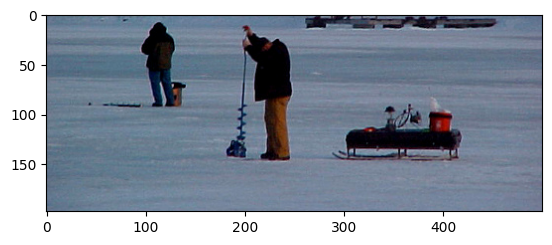

In [38]:
generate_caption("102351840_323e3de834.jpg")

---------------------Actual---------------------
startseq man standing on rocky mountain with gray clouds in the background endseq
startseq man without shirt is walking on top of lots of rocks endseq
startseq shirtless man is walking on rocky hill endseq
startseq shirtless man with backpack endseq
startseq topless person with backpack is shown against on pile of rocks with cloudy background endseq
--------------------Predicted--------------------
startseq man is hiking on rocky hill endseq


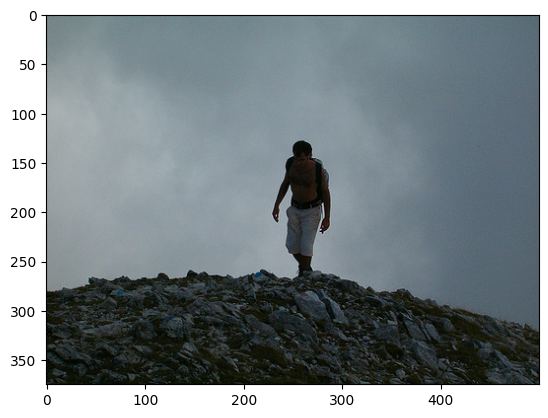

In [32]:
generate_caption("1277185009_06478dd457.jpg")

---------------------Actual---------------------
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
--------------------Predicted--------------------
startseq boston terrier is running in the grass endseq


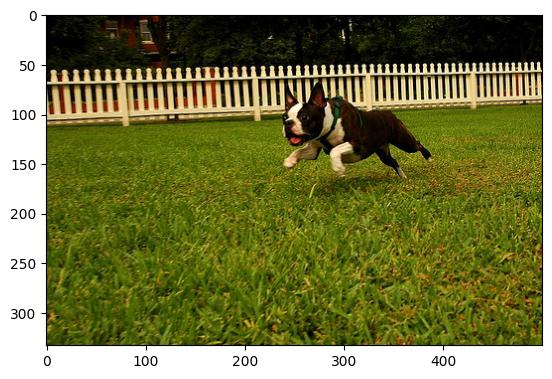

In [37]:
generate_caption("1009434119_febe49276a.jpg")

---------------------Actual---------------------
startseq grey dog beside black and white dog running in green grass endseq
startseq two dogs are wrestling in grassy field endseq
startseq "two dogs playing in field wrestling with each other" endseq
startseq two dogs run along grassy field while one bites the other endseq
startseq two dogs wrestle in field endseq
--------------------Predicted--------------------
startseq two dogs run through field endseq


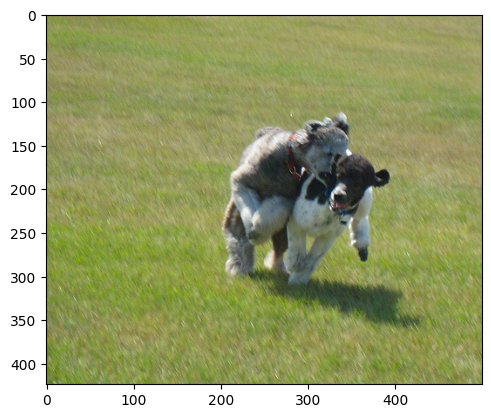

In [34]:
generate_caption("1164131282_b30926f332.jpg")

---------------------Actual---------------------
startseq dog jumping into swimming pool endseq
startseq grey dog runs alongside pool while yellow dog jumps into the pool endseq
startseq one dog is jumping into pool while another runs alongside the pool 's edge endseq
startseq one tan dog jumping in pool while the other grey dog is on the deck endseq
startseq two dogs jumping into swimming pool endseq
--------------------Predicted--------------------
startseq dog jumps into pool while another dog jumps for it endseq


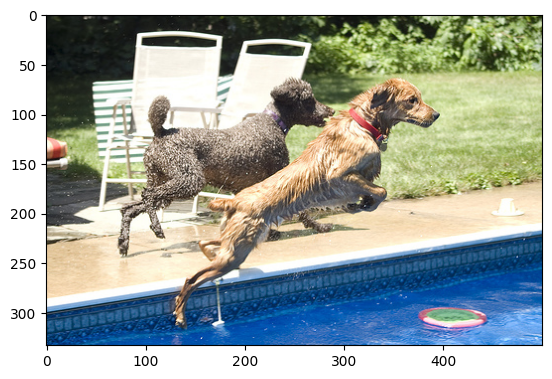

In [36]:
generate_caption("1189977786_4f5aaed773.jpg")

---------------------Actual---------------------
startseq girl in brown dress surrounded by children closes her eyes endseq
startseq girl in yellow dress with the sun shining on her face endseq
startseq girl in yellow dress is standing with her eyes closed in busy park endseq
startseq young girl in white dress endseq
startseq children at park endseq
--------------------Predicted--------------------
startseq three children in bathing suits are standing in front of fountain endseq


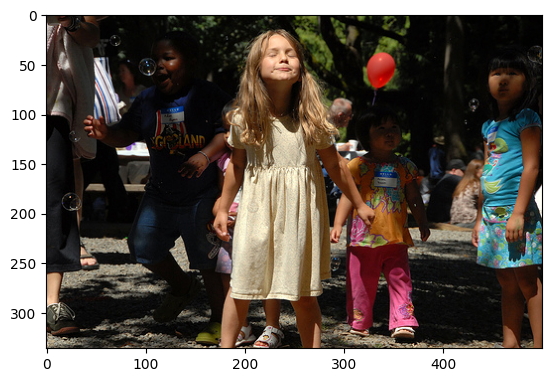

In [35]:
generate_caption("1211015912_9f3ee3a995.jpg")

---------------------Actual---------------------
startseq boy in green shirt is looking down at many inflatable boats endseq
startseq boy in green shirt watches kayakers endseq
startseq boy looks over railing at the many boats and rafts below in the water endseq
startseq young boy overlooking crowd of inflatable boats endseq
startseq young boy wearing jersey looks down over ledge at many boats in the water endseq
--------------------Predicted--------------------
startseq man in green shirt is jumping into pool endseq


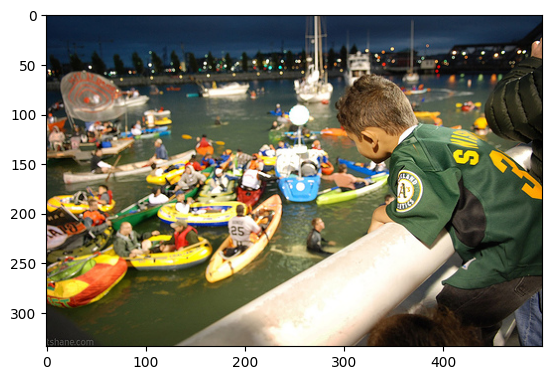

In [39]:
generate_caption("1042020065_fb3d3ba5ba.jpg")

---------------------Actual---------------------
startseq closeup of white dog that is laying its head on its paws endseq
startseq large white dog lying on the floor endseq
startseq white dog has its head on the ground endseq
startseq white dog is resting its head on tiled floor with its eyes open endseq
startseq white dog rests its head on the patio bricks endseq
--------------------Predicted--------------------
startseq white dog rests its head on the patio bricks endseq


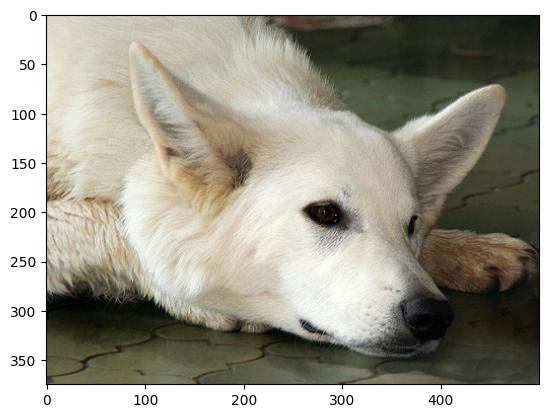

In [42]:
generate_caption("1084040636_97d9633581.jpg")

---------------------Actual---------------------
startseq little boy stands in the surf endseq
startseq small child wades through the water while being guided by another person endseq
startseq young boy laughs while splashing in the ocean endseq
startseq young boy wearing colorful bathing suit splashing in the ocean endseq
startseq young child splashing in water endseq
--------------------Predicted--------------------
startseq baby in the water endseq


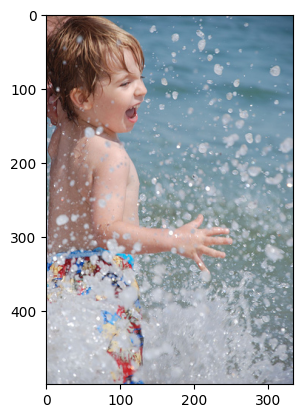

In [44]:
generate_caption("1118557877_736f339752.jpg")

---------------------Actual---------------------
startseq korean man sells soda endseq
startseq man is sitting at an outside bar near many soda and beer cans endseq
startseq man wearing glasses with aluminum cans lined up in front of him endseq
startseq an elderly man is smiling while sitting in front of row of soda cans endseq
startseq vendor selling drinks in stall endseq
--------------------Predicted--------------------
startseq korean man sells soda endseq


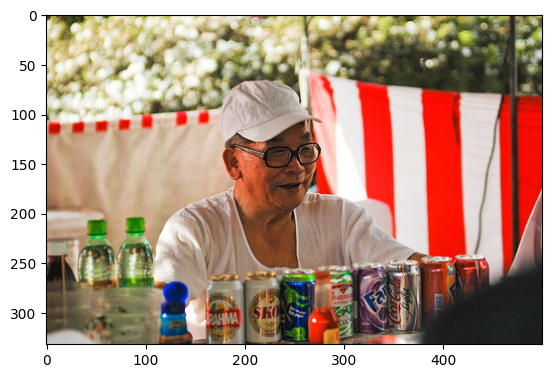

In [51]:
generate_caption("1234817607_924893f6e1.jpg")